<a href="https://colab.research.google.com/github/fle1scha/DL4NTP/blob/main/DL4NTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add all imports and print TensorFlow version to verify it is correct version

In [19]:
import tensorflow as tf
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import datetime as dt

from datetime import datetime, date
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers  import LSTM
from tensorflow.keras.layers  import TimeDistributed
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array
from numpy import cumsum
from pandas.tseries.holiday import USFederalHolidayCalendar
from random import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

print(keras.__version__)

2.6.0


# Read in Data

1. Mount Google Drive file system

In [20]:
# from google.colab import drive # Hosting the file in Google Drive, need to mount the drive so it is accessible
# # Currently Google forces an authorisation code, local runtime would rectify this
# drive.mount('/content/gdrive', force_remount=True) #force_remount forces Google t

In [21]:
#Read in SANREN dataset.
with open('SANREN_large.txt') as f:
  SANReN = f.readlines()

# ***Data Preprocessing***

In [22]:
#Clean dataframe headers and create labels.
headings_line = SANReN[0].split()

headings_line[4:7] = [''.join(headings_line[4:7])] #Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])] #Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line = headings_line[0:6] + headings_line[8:13] #Remove 'Flags', 'Tos', and 'Flows'.

print(headings_line)

['Date', 'first-seen', 'Duration', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp']


In [23]:
#Clean time-series data points. 
framedata = []
for i in range(1, 3001):
  data_line = SANReN[i].split()

  if (data_line[11] == "M" and (data_line[14] == 'M' or data_line[14] == 'G')): #Bytes and BPS in megabytes
    #print("1 and 2") 
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    if (data_line[9] == 'G'):
      data_line[9] = float(data_line[9])*100000000 #Change G bytes into byte measurement. 
    else:
      data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
   
 
  elif (data_line[13] == 'M'): #BPS measured in megabytes
    #print("2")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  #data_line  = np.asarray(data_line) #Turn each line into a NumPy array.
  framedata.append(data_line) #append each line to 'mother' array.

In [24]:
#Convert Numpy array into Pandas dataframe.
df = pd.DataFrame(np.array(framedata), columns=headings_line) 
print(df.shape)

(3000, 11)


In [25]:
#Define all data types correctly. 
df['Datetimetemp'] = df['Date'] + 'T' + df['first-seen'] #Combine Date and first-seen
df = df.astype({'Date': 'datetime64[ns]'})
df["Day"] = df['Date'].dt.dayofweek #Created Day variable.
#df['Date'] = df['Date'].map(dt.datetime.toordinal)
df = df.astype({'first-seen': np.datetime64})
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})

#Create binary Weekend variable.
df['Weekend'] = 0
df.loc[df['Day'] == 5 , 'Weekend'] = 1
df.loc[df['Day'] == 6 , 'Weekend'] = 1

#Insert combined Datetime at front of dataframe.
df.insert(0, 'Datetime', df['Datetimetemp'])
df['Datetime'] = df.Datetime.astype('datetime64[ns]')
df['Datetime'] = df.Datetime.astype('int64') #Convert Datetime into an integer representation. This is a deprecated method. 

#Define university holiday calender
holidays = pd.date_range(start='2020-1-1', end='2020-3-14', freq = '1D')
holidays = holidays.append(pd.date_range(start='2020-5-1', end='2020-5-9', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-07-08', end='2020-08-02', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-09-18', end='2020-09-27', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-11-24', end='2020-12-31', freq='1D'))
print(df['Date'])
#Add Holiday column to dataframe.
df['Holiday'] = 0
df.loc[(df['Date']) == any(holidays.date), 'Holiday'] = 1 #Can't get this to work



0      2020-07-04
1      2020-07-04
2      2020-07-04
3      2020-07-04
4      2020-07-04
          ...    
2995   2020-07-04
2996   2020-07-04
2997   2020-07-04
2998   2020-07-04
2999   2020-07-04
Name: Date, Length: 3000, dtype: datetime64[ns]


/var/folders/r0/zt6nwh1x7_lb4ddlk_6krd2c0000gn/T/ipykernel_38079/2287329169.py:24: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['Datetime'] = df.Datetime.astype('int64') #Convert Datetime into an integer representation. This is a deprecated method.


In [26]:
#Delete unused columns.
del df['Date']
del df['first-seen']
del df['Datetimetemp']

In [27]:
#One-Hot Encoding
category_df = (df.copy().drop(['Day', 'Weekend', 'Holiday', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Datetime', 'Duration', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp'], axis = 1))
for x in category_df.columns:
    #Printing unique values per categorical variable
    print(x ,':', len(category_df[x].unique()))

encoder = OneHotEncoder(sparse=False)
#Transform data
onehot = encoder.fit_transform(category_df)
category_df = pd.DataFrame(np.array(onehot))


Proto : 4


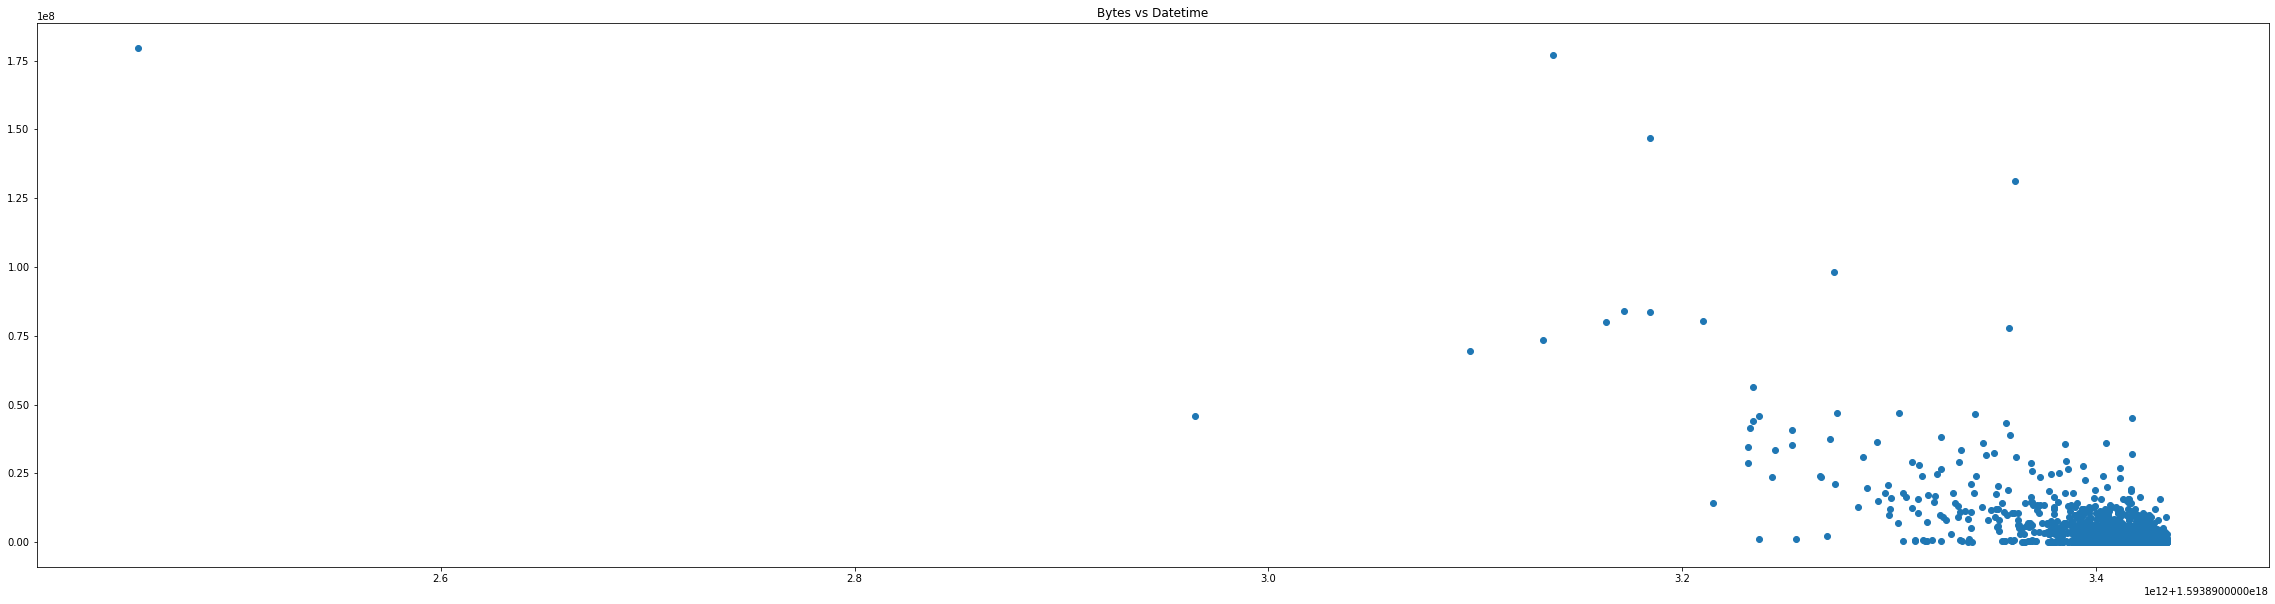

In [28]:
#A plot of Bytes vs Datetime
plt.figure(figsize=(40,10))
plt.title("Bytes vs Datetime")
plt.scatter(df['Datetime'], df['Bytes']) #changed to scatter because line graph is very bunched. fromordinal only differentiates by date so will have to find a way to get it into seconds. 


In [29]:
#Add encoded categorical data to regression data
df = (df.copy().drop(['Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis = 1)).copy()
print(df.shape)
df = pd.concat([df, category_df], axis = 1)
print(df.shape)

(3000, 12)
(3000, 16)


In [30]:
#Split data into both training and test set. Use 80/20 split.
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the sample.
train = df.iloc[:-test_size,:].copy()  #Not copying here threw an error. Must be careful not to keep two copies for memory reasons.
test = df.iloc[-test_size:,:].copy() 

X_train = train.drop('Bytes',axis=1).copy() #Drop target variable from training data. 
y_train = train[['Bytes']].copy() # The double brackets are to keep Bytes in a pandas dataframe format, otherwise it will be pandas Series.
print(X_train.shape, y_train.shape) #Check shape of training variables. 

(2400, 15) (2400, 1)


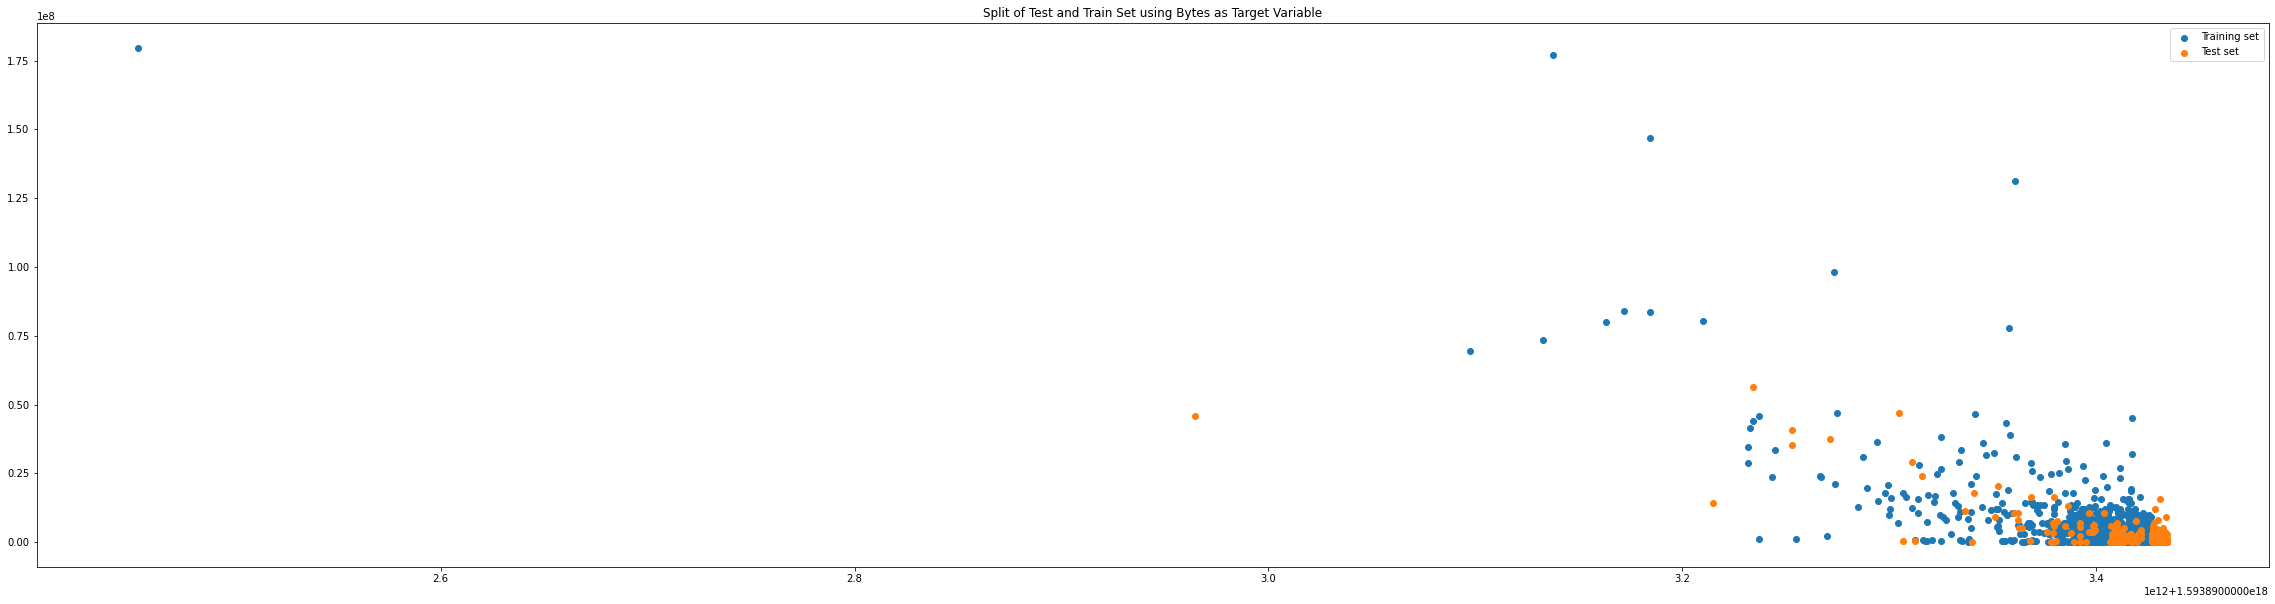

In [31]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as Target Variable")
plt.scatter(train['Datetime'],train['Bytes'],label='Training set')
plt.scatter(test['Datetime'],test['Bytes'],label='Test set')
plt.legend()

In [32]:
#Scale training dating
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scikit MinMixScaler allows all variables to be normalised between 0 and 1.
Xscaler.fit(X_train) #Compute the minimum and maximum to be used for later scaling
scaled_X_train = Xscaler.transform(X_train) #Scale features of X according to feature_range.

print(X_train.shape) #X_train shape is the same as earlier but now scaled. 
print(scaled_X_train) #Demonstrate normalised data. 

ValueError: could not convert string to float: '146.231.4.0:47837'

In [ ]:
#Scale training response
Yscaler = MinMaxScaler(feature_range=(0, 1)) #apply same normalisation to response. 
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

print(scaled_y_train.shape) #Shape is constant. 

In [ ]:
#Define input_shape for LSTM
n_input = 100 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 100 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print(train_generator[0][0].shape)

# Simple LSTM Implementation

In [ ]:
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
simple_LSTM_model = Sequential() 
# Model is an LSTM, 50 is dimentionality of the output, activation function is relu
simple_LSTM_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features))) 
# Dense layer as the first layer of the model
simple_LSTM_model.add(Dense(1)) 
# Compile the model with the adam optimizer, loss measured in Mean Squarred Error
# Adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.compile(optimizer='adam', loss='mse') 
# Print out a summary of the LSTM to check that it was compiled correctly 
simple_LSTM_model.summary()

In [ ]:
#Fit the data to the model and train.
simple_LSTM_model.fit(train_generator, epochs=20, verbose = 1) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
#Testing x data
X_test = test.drop('Bytes', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=100, batch_size=b_size) #There are only 17 samples in the test set so it cannot look back.
print(test_generator[0][0].shape)

In [ ]:
#Predicted LSTM response for bytes
y_pred_scaled = simple_LSTM_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
simple_lstm_results.plot()
print(simple_lstm_results)

In [ ]:
#Predicted  LSTM response in megabytes
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
simple_lstm_results['residuals'] = np.square(
    simple_lstm_results.y_pred - simple_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
simple_LSTM_mse = simple_lstm_results.residuals.sum() * (1/len(simple_lstm_results))
print('MSE: ' + str(np.round(simple_LSTM_mse, 3)))

# Bidirectional LSTM Implementation

In [ ]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
bidirectional_lstm_model = Sequential() 
bidirectional_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False, activation="relu"), input_shape=(n_input, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(loss='mse', optimizer='adam')
bidirectional_lstm_model.summary()

In [ ]:
bidirectional_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = bidirectional_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)


In [ ]:
y_pred_scaled = bidirectional_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(bidirectional_lstm_results)
bidirectional_lstm_results.plot()

Predictions made in megabytes

In [ ]:
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print('MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))

# Stacked LSTM Implementation

In [ ]:
stacked_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
stacked_lstm_model.add(LSTM(50, return_sequences=True, activation="relu", input_shape=(n_input, n_features)))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(LSTM(50))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(loss='mse', optimizer='adam')
stacked_lstm_model.summary()

In [ ]:
stacked_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = stacked_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
y_pred_scaled = stacked_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(stacked_lstm_results)
stacked_lstm_results.plot()

Predictions made in megabytes

In [ ]:
stacked_lstm_results = pd.DataFrame(
    {'y_true': test['Bytes'].values[100:]/1000000, 'y_pred': y_pred.ravel()/1000000})
stacked_lstm_results['residuals'] = np.square(
    stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * \
    (1/len(stacked_lstm_results))
print('MSE: ' + str(np.round(stacked_LSTM_mse, 3)))
